**IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm 
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

**MOUNTING THE DRIVE**

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("/content/drive/My Drive/cs2")

**LOADING CHEXNET MODEL**

In [4]:
#The trained weights of this model is from https://github.com/brucechou1983/CheXNet-Keras
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py

from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))

base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape)
pred=Dense(14,"sigmoid")(base.output)

chexnet=Model(inputs=base.input,outputs=pred)
chexnet.load_weights("chexnet_weights.h5")

chexnet.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

Here we extract the Image features using chexnet model.We use attention mechanism on the image features and give that context vector to the decoder,based on this context vector the decoder generates the word 

In [5]:
final_chexnet_model=Model(inputs=chexnet.inputs,outputs=chexnet.layers[-2].output,name="Chexnet_model")

**LOADING DATA**

In [4]:
train_dataset = pd.read_csv('Train_Data.csv')
test_dataset = pd.read_csv('Test_Data.csv')
cv_dataset = pd.read_csv('CV_Data.csv')

In [5]:
train_dataset.head()

,Person_id,Image-1,Image-2,Findings
0,x ray data/CXR1_1_IM-0001_0,x ray data/CXR1_1_IM-0001-3001.png,x ray data/CXR1_1_IM-0001-4001.png,SOS the cardiac silhouette and mediastinum siz...
1,x ray data/CXR10_IM-0002_0,x ray data/CXR10_IM-0002-1001.png,x ray data/CXR10_IM-0002-2001.png,SOS the cardiomediastinal silhouette within no...
2,x ray data/CXR100_IM-0002_0,x ray data/CXR100_IM-0002-1001.png,x ray data/CXR100_IM-0002-2001.png,SOS both lungs are clear and epanded . heart ...
3,x ray data/CXR1000_IM-0003_0,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-2001.png,SOS there increased opacity within the right u...
4,x ray data/CXR1000_IM-0003_1,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-3001.png,SOS there increased opacity within the right u...


In [6]:
print(train_dataset.shape)
print(test_dataset.shape)
print(cv_dataset.shape)

(2758, 4)
(399, 4)
(550, 4)


In [7]:
#for removing SOS and EOS from findings
def remove(x):
    return x[4:-4]

In [8]:
train_dataset['Findings'] = train_dataset['Findings'].apply(lambda x : remove(x))
test_dataset['Findings'] = test_dataset['Findings'].apply(lambda x : remove(x))
cv_dataset['Findings'] = cv_dataset['Findings'].apply(lambda x : remove(x))

In [9]:
train_dataset.head()

,Person_id,Image-1,Image-2,Findings
0,x ray data/CXR1_1_IM-0001_0,x ray data/CXR1_1_IM-0001-3001.png,x ray data/CXR1_1_IM-0001-4001.png,the cardiac silhouette and mediastinum size ar...
1,x ray data/CXR10_IM-0002_0,x ray data/CXR10_IM-0002-1001.png,x ray data/CXR10_IM-0002-2001.png,the cardiomediastinal silhouette within normal...
2,x ray data/CXR100_IM-0002_0,x ray data/CXR100_IM-0002-1001.png,x ray data/CXR100_IM-0002-2001.png,both lungs are clear and epanded . heart and ...
3,x ray data/CXR1000_IM-0003_0,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-2001.png,there increased opacity within the right upper...
4,x ray data/CXR1000_IM-0003_1,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-3001.png,there increased opacity within the right upper...


In [10]:
#finding the number of words in each report
leng=[]
for rep in train_dataset["Findings"]:
  leng.append(len(rep.split()))

print("90th percentile is ",np.percentile(leng,90))
print("99th percentile is ",np.percentile(leng,99))
print("99.9th percentile is ",np.percentile(leng,99.9))
print("Maximum length of report is ",np.max(leng))

90th percentile is  49.0
99th percentile is  73.0
99.9th percentile is  89.70100000000275
Maximum length of report is  153


Here we see that 99.9% of the reports contain less than 100 words even though the maximum words in a report is 155

In [ ]:
# we obtain the image features from the chexnet model and we predict(7,7,1024) dimensional vector for every image.
#As we have two images for every patient we concatenate them and we perform attention mechanism for that we convert this into a 98,1024 dimensional tensor

def image_feature_extraction(image1,image2):
   
  image_1 = Image.open(image1)
  image_1= np.asarray(image_1.convert("RGB"))
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

  #normalising the image 
  image_1=image_1/255
  image_2=image_2/255

  #resize the image into (224,224)
  image_1 = cv2.resize(image_1,(224,224))
  image_2 = cv2.resize(image_2,(224,224))
    
  image_1= np.expand_dims(image_1, axis=0)
  image_2= np.expand_dims(image_2, axis=0)
    
 #now we have read two image per patient. this is goven to the chexnet model for feature extraction
    
  image_1_out=final_chexnet_model(image_1)
  image_2_out=final_chexnet_model(image_2)
  #conactenate along the width
  conc=np.concatenate((image_1_out,image_2_out),axis=2)
  #reshape into(no.of images passed, length*breadth, depth)
  image_feature=tf.reshape(conc, (conc.shape[0], -1, conc.shape[-1]))
  
  return image_feature

In [ ]:
train_dataset.shape

(2758, 4)

In [ ]:
cv_dataset.shape

(550, 4)

In [ ]:
train_features=np.zeros((2758,98,1024))

for row in tqdm(range(train_dataset.shape[0])):
  image_1=train_dataset.iloc[row]["Image-1"]
  image_2=train_dataset.iloc[row]["Image-2"]
  train_features[row]=(image_feature_extraction(image_1,image_2))

100%|██████████| 2758/2758 [29:16<00:00,  1.57it/s]


In [ ]:
cv_features=np.zeros((550,98,1024))

for row in tqdm(range(cv_dataset.shape[0])):
  image_1=cv_dataset.iloc[row]["Image-1"]
  image_2=cv_dataset.iloc[row]["Image-2"]
  cv_features[row]=(image_feature_extraction(image_1,image_2))

100%|██████████| 550/550 [06:14<00:00,  1.47it/s]


In [ ]:
test_features=np.zeros((399,98,1024))
# test_features=np.zeros((764,98,1024))

for row in tqdm(range(test_dataset.shape[0])):
  image_1=test_dataset.iloc[row]["Image-1"]
  image_2=test_dataset.iloc[row]["Image-2"]
  test_features[row]=(image_feature_extraction(image_1,image_2))

100%|██████████| 399/399 [05:55<00:00,  1.12it/s]


In [ ]:
#saving the image features
'''np.save("train_features_attention",train_features)
np.save("test_features_attention",test_features)
np.save("cv_features_attention",cv_features)'''

In [56]:
#loading the image features
train_features=np.load("train_features_attention.npy")
test_features=np.load("test_features_attention.npy")
cv_features = np.load("cv_features_attention.npy")

In [57]:
#checking the shape of features
print(train_features.shape)
print(cv_features.shape)
print(test_features.shape)

(2758, 98, 1024)
(558, 98, 1024)
(399, 98, 1024)


In [11]:
#processing the text feature for embedding
train_report=["<sos> "+text+" <eos>" for text in train_dataset["Findings"].values]
test_report=["<sos> "+text+" <eos>" for text in test_dataset['Findings'].values]
cv_report = ["<sos> "+text+" <eos>" for text in cv_dataset['Findings'].values]

In [12]:
#we are adding sos and eos in front and back of report because it will be useful for decoder to generate the next word
train_report_in=["<sos> "+text for text in train_dataset["Findings"].values]
train_report_out=[text+" <eos>" for text in train_dataset["Findings"].values]
test_report_in=["<sos> "+text for text in test_dataset["Findings"].values]
test_report_out=[text+ " <eos>"for text in test_dataset["Findings"].values]
cv_report_in=[ "<sos> "+text for text in cv_dataset["Findings"].values]
cv_report_out=[text+" <eos>" for text in cv_dataset["Findings"].values]

In [13]:
print(train_report_in[0])
print("*"*100)
print(train_report_out[0])

<sos> the cardiac silhouette and mediastinum size are within normal limits .  there no pulmonary edema .  there no focal consolidation .  there are no pleural effusion .  there no evidence pneumothora . 
****************************************************************************************************
the cardiac silhouette and mediastinum size are within normal limits .  there no pulmonary edema .  there no focal consolidation .  there are no pleural effusion .  there no evidence pneumothora .  <eos>


In [14]:
#Here we take batch size of 10 and maximum length of report as 100 
bs=10
max_len=100

In [15]:
#Obtaining the text embeddings of the report
# we use the tensorflow tokenizer to convert the text into tokens
#we also pad the sequences to a length 300 which is around the 90th percentile of the lengths of the report

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 

seq=token.texts_to_sequences(train_report_in)
train_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(train_report_out)
train_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

seq=token.texts_to_sequences(cv_report_in)
cv_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(cv_report_out)
cv_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

In [16]:
print(train_padded_inp[98])

[ 6  2 13 15  8 20 53 46 17  5 19  1  2 14  4 80 16 25 32  1  3  9 12 11
 45  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [17]:
print(train_padded_out[98])

[ 2 13 15  8 20 53 46 17  5 19  1  2 14  4 80 16 25 32  1  3  9 12 11 45
  1  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [18]:
len(train_padded_out)

2758

In [19]:
#using fast embedding
embeddings_index=dict()
f = open('crawl-300d-2M.vec',encoding="utf8")
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 1426/1426 [00:00<00:00, 142413.39it/s]

Done


In [20]:
print(token.word_index)

{'.': 1, 'the': 2, 'no': 3, 'are': 4, 'normal': 5, '<sos>': 6, '<eos>': 7, 'and': 8, 'pleural': 9, 'there': 10, 'pneumothora': 11, 'effusion': 12, 'heart': 13, 'lungs': 14, 'size': 15, 'focal': 16, 'within': 17, 'clear': 18, 'limits': 19, 'pulmonary': 20, 'consolidation': 21, 'silhouette': 22, 'right': 23, 'mediastinal': 24, 'airspace': 25, 'cardiomediastinal': 26, 'left': 27, 'acute': 28, 'lung': 29, 'with': 30, 'unremarkable': 31, 'disease': 32, 'stable': 33, 'spine': 34, 'mediastinum': 35, 'structures': 36, 'changes': 37, 'contours': 38, 'thoracic': 39, 'bony': 40, 'contour': 41, 'mild': 42, 'degenerative': 43, 'large': 44, 'seen': 45, 'appear': 46, 'opacity': 47, 'osseous': 48, 'without': 49, 'calcified': 50, 'cardiac': 51, 'effusions': 52, 'vascularity': 53, 'intact': 54, 'abnormality': 55, 'for': 56, 'visualized': 57, 'evidence': 58, 'opacities': 59, 'upper': 60, 'lateral': 61, 'vasculature': 62, 'chest': 63, 'lobe': 64, 'aorta': 65, 'noted': 66, 'identified': 67, 'volumes': 68, 

In [21]:
#checking how many words are there in the embedding file
x = []
for keys in embeddings_index:
  x.append(keys)
print(len(x))

2000000


In [22]:
t_w = []
for keys in token.word_index:
  t_w.append(keys)

print(len(t_w)) 

1426


In [23]:
#checking how many common words are present in our vocab and embedding file
t_ws = set (t_w)
x_s  = set (x)
com = (x_s & t_ws)
print('{0} % of train words present in embedding file'.format(len(com)/len(t_ws)*100))

88.218793828892 % of train words present in embedding file


**MODEL WITH ATTENTION MECHANISM**

We extract image features and pass it to the encoder modeule to give output
For decoder we pass the decoder hidden state and encoder output to the attention model which calculate the attention weights Now using the attention weights and encoder output we calculate the context vector

Now we take context vector and embedding vector of decoder input and concatenate it and pass it to gru.

Then gru ouput is passed to final dense layer

In [ ]:
enc_units=64
embedding_dim=300
dec_units=64
att_units=64

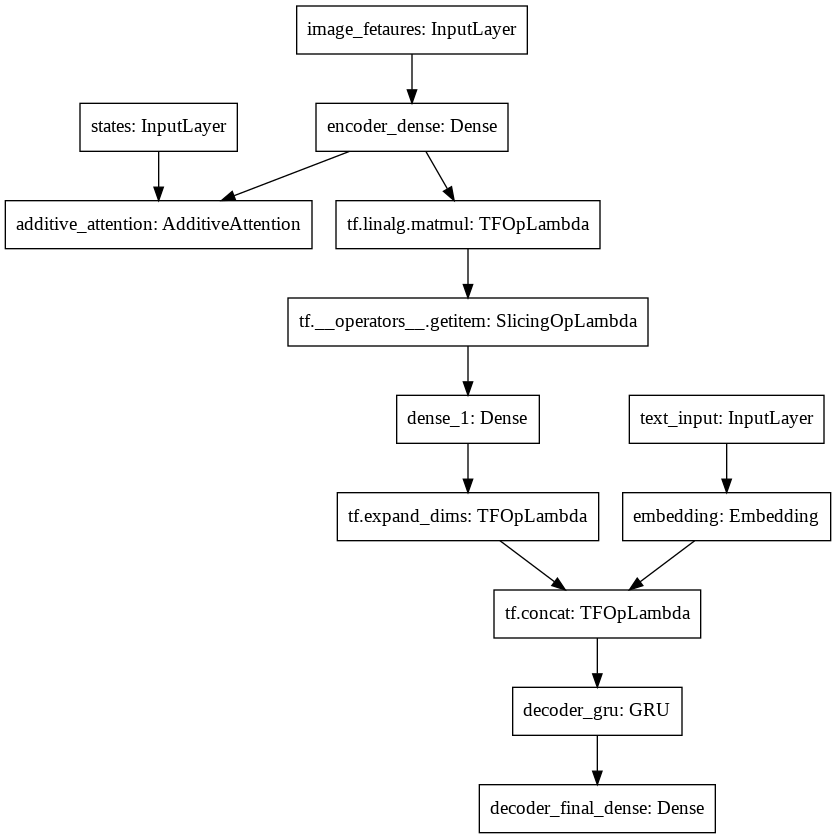

In [ ]:
input_img=Input(shape=(98,1024),name="image_fetaures")
input_txt=Input(shape=(max_len),name="text_input")

#encoder model
en_out=Dense(enc_units,activation="relu",name="encoder_dense")(input_img)
enc_out=tf.keras.layers.Dropout(0.5)(en_out)

state_h= Input(shape=(bs,enc_units),name="states")
#decoder model with attention

emb_out=tf.keras.layers.Embedding(vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_txt)
weights=tf.keras.layers.AdditiveAttention()([state_h,en_out])
context_vector=tf.matmul(en_out,weights,transpose_b=True)[:,:,0]
context_vector=Dense(embedding_dim)(context_vector)
result=tf.concat([tf.expand_dims(context_vector, axis=1),emb_out],axis=1)
gru_out,state=tf.keras.layers.GRU(dec_units,return_sequences=True,return_state=True,name="decoder_gru")(result)
out=tf.keras.layers.Dense(vocab_size,name="decoder_final_dense") (gru_out)
en_de=Model(inputs=[input_txt,input_img,state_h],outputs=out)

keras.utils.plot_model(en_de)

In [ ]:
#encoder model
#https://www.tensorflow.org/tutorials/text/nmt_with_attention
class Encoder(tf.keras.Model):
  def __init__(self,units):
    super().__init__()
    self.units=units
    
  
  def build(self,input_shape):
    self.dense1=Dense(self.units,activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 0),name="encoder_dense")
    self.maxpool=tf.keras.layers.Dropout(0.5)

  def call(self,input_):
    enc_out=self.maxpool(input_)
    enc_out=self.dense1(enc_out) 
    
    return enc_out
    
  def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state
      If batch size is 32- Hidden state shape is [32,units]
      '''
      hidden=tf.zeros((batch_size,self.units))
      
      return hidden

In [ ]:
#this is the attention class. 
#Here the input to the decoder and the gru hidden state at the pevious time step are given, and the context vector is calculated
#This context vector is calculated uisng the attention weights. This context vector is then passed to the decoder model
#Here conact function is used for calaculating the attention weights


class Attention(tf.keras.layers.Layer):

  def __init__(self,att_units):

    super().__init__()
    
    self.att_units=att_units

  def build(self,input_shape):
    self.wa=tf.keras.layers.Dense(self.att_units)
    self.wb=tf.keras.layers.Dense(self.att_units)
    self.v=tf.keras.layers.Dense(1)
  
    
  def call(self,decoder_hidden_state,encoder_output):
   
    x=tf.expand_dims(decoder_hidden_state,1)
    
    # print(x.shape)
    # print(encoder_output.shape)
      
    alpha_dash=self.v(tf.nn.tanh(self.wa(encoder_output)+self.wb(x)))
    
    alphas=tf.nn.softmax(alpha_dash,1)

    # print("en",encoder_output.shape)
    # print("al",alphas.shape)
    
    context_vector=tf.matmul(encoder_output,alphas,transpose_a=True)[:,:,0]
    # context_vector = alphas*encoder_output
    # print("c",context_vector.shape)


    return (context_vector,alphas)

In [ ]:
#This class will perform the decoder task.
#The main decoder will call this onestep decoder at every time step. This one step decoder in turn class the atention model and return the ouptput at time step t.
#This output is passed through the final softmax layer with output size =vocab size, and pass this result to the main decoder model


class One_Step_Decoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, input_length, dec_units ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    
    self.att_units=att_units
    self.vocab_size=vocab_size
    self.embedding_dim=embedding_dim
    self.input_length=input_length
    
    self.dec_units=dec_units
    self.attention=Attention(self.att_units)
  #def build(self,inp_shape):
    self.embedding=tf.keras.layers.Embedding(self.vocab_size,output_dim=self.embedding_dim,
                                             input_length=self.input_length,mask_zero=True,trainable=False,weights=[embedding_matrix])

    self.gru=tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform',name="decoder_gru")
    self.dense=tf.keras.layers.Dense(self.vocab_size,name="decoder_final_dense") 
    self.dense_2=tf.keras.layers.Dense(self.embedding_dim,name="decoder_dense2") 


  def call(self,input_to_decoder, encoder_output, state_h):
    
    embed=self.embedding(input_to_decoder)
    
    context_vector,alpha=self.attention(state_h,encoder_output)
    
    context_vector=self.dense_2(context_vector) 
    
    result=tf.concat([tf.expand_dims(context_vector, axis=1),embed],axis=-1)
    
   
    output,decoder_state_1=self.gru(result,initial_state=state_h)
    out=tf.reshape(output,(-1,output.shape[-1]))

    out=tf.keras.layers.Dropout(0.5)(out)
    
    dense_op=self.dense(out)
    
    return dense_op,decoder_state_1,alpha

In [ ]:
#https://www.tensorflow.org/tutorials/text/transformer#decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, output_length, dec_units,att_units):
      super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.onestep=One_Step_Decoder(vocab_size, embedding_dim, output_length, dec_units,att_units)


        
    def call(self, input_to_decoder,encoder_output,state_1):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        all_outputs=tf.TensorArray(tf.float32,input_to_decoder.shape[1],name="output_array")
        for step in range(input_to_decoder.shape[1]):
          output,state_1,alpha=self.onestep(input_to_decoder[:,step:step+1],encoder_output,state_1)

          all_outputs=all_outputs.write(step,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,enc_units,embedding_dim,vocab_size,output_length,dec_units,att_units,batch_size):
        super().__init__()

        
        self.batch_size=batch_size
        self.encoder =Encoder(enc_units)
        self.decoder=Decoder(vocab_size,embedding_dim,output_length,dec_units,att_units)
        
  
    #Coompute the image features using feature extraction model and pass it to the encoder
    # This will give encoder ouput
   # Pass the decoder sequence,encoder_output,initial states to Decoder
    # return the decoder output

  
  def call(self, data):
        features,report  = data[0], data[1]
        
        encoder_output= self.encoder(features)
        state_h=self.encoder.initialize_states(self.batch_size)
        
        output= self.decoder(report, encoder_output,state_h)
      
        return output

In [ ]:
model  = encoder_decoder(enc_units,embedding_dim,vocab_size,max_len,dec_units,att_units,bs)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='auto')

def custom_lossfunction(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [ ]:
model.compile(optimizer=optimizer,loss=custom_lossfunction)

In [ ]:
red_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2, min_lr=0.0001)
ckpt=tf.keras.callbacks.ModelCheckpoint("model_3/wts",monitor='val_loss', verbose=1, save_best_only=True,save_freq='epoch',save_weights_only=False, mode='auto')

In [ ]:

model.fit([train_features[:2750],train_padded_inp[:2750]],train_padded_out[:2750],validation_data=([cv_features[:550],cv_padded_inp[:550]],cv_padded_out[:550]),
          batch_size=bs,epochs=50,callbacks=[red_lr,ckpt])

Epoch 1/50
275/275 [==============================] - 146s 193ms/step - loss: 1.1181 - val_loss: 0.5921

Epoch 00001: val_loss improved from inf to 0.59207, saving model to model_3/wts
Epoch 2/50
275/275 [==============================] - 35s 126ms/step - loss: 0.5424 - val_loss: 0.5292

Epoch 00002: val_loss improved from 0.59207 to 0.52921, saving model to model_3/wts
Epoch 3/50
275/275 [==============================] - 35s 127ms/step - loss: 0.5146 - val_loss: 0.4645

Epoch 00003: val_loss improved from 0.52921 to 0.46455, saving model to model_3/wts
Epoch 4/50
275/275 [==============================] - 34s 124ms/step - loss: 0.4454 - val_loss: 0.4086

Epoch 00004: val_loss improved from 0.46455 to 0.40856, saving model to model_3/wts
Epoch 5/50
275/275 [==============================] - 35s 128ms/step - loss: 0.4142 - val_loss: 0.3661

Epoch 00005: val_loss improved from 0.40856 to 0.36613, saving model to model_3/wts
Epoch 6/50
275/275 [==============================] - 34s 125ms

Here I tried with different epochs like 20,30 and 50 as the loss is decreasing and settled with 50 epochs.

In [ ]:
#loading the weights
model.load_weights("model_2/wts")


In [ ]:
def take_second(elem):
    return elem[1]

**TESTING**

In [ ]:
#https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/
def beam_search(image1,image2, beam_index):

    hidden_state =  tf.zeros((1, enc_units))

    image_features=image_feature_extraction(image1,image2)

    encoder_out = model.layers[0](image_features)

    start_token = [token.word_index["<sos>"]]
    dec_word = [[start_token, 0.0]]
    while len(dec_word[0][0]) < max_len:
        temp = []
        for word in dec_word:
            
            predict, hidden_state,alpha = model.layers[1].onestep(tf.expand_dims([word[0][-1]],1), encoder_out, hidden_state)
           
           
            word_predict = np.argsort(predict[0])[-beam_index:]
            for i in word_predict:

                next_word, probab = word[0][:], word[1]
                next_word.append(i)
                probab += predict[0][i] 
                temp.append([next_word, probab.numpy()])
        dec_word = temp
        # Sorting according to the probabilities scores
        
        
        dec_word = sorted(dec_word, key=take_second)
       
        # Getting the top words
        dec_word = dec_word[-beam_index:] 
        
     
    final = dec_word[-1]
    
    report =final[0]
    score = final[1]
    temp = []
    
    for word in report:
      if word!=0:
        if word != token.word_index['<eos>']:
            temp.append(token.index_word[word])
        else:
            break 

    rep = ' '.join(e for e in temp)        
    
    return rep, score

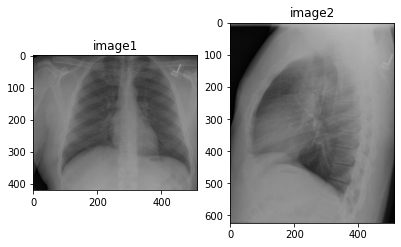

ACTUAL REPORT:  <sos> lungs are clear without focal consolidation effusion pneumothora .  normal heart size .  no suspicious pulmonary nodules masses .  bony thora and soft tissues grossly unremarkable .  <eos>
GENERATED REPORT:  <sos> the mediastinum . no pleural effusion .
BLEU SCORE IS:  0.5946035575013605
time required for the evaluation is  4.241926193237305


In [ ]:
#checking on random train points
import random 
start=time.time()
#i=random.sample(range(train_dataset.shape[0]),1)[0]
i= 73
img1=train_dataset.iloc[i]["Image-1"]
img2=train_dataset.iloc[i]["Image-2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=train_report[i]

actual_ref = actual.split()
#actual_ref = [e for e in actual_ref if e not in ('SOS', 'EOS')]
result_ref = result.split()
#result_ref = [e for e in result_ref if e not in ('sos', 'eos')]
#print(actual_ref,result_ref)
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual_ref,result_ref,weights=(0.25,0.25,0.25,0.25)))

print("time required for the evaluation is ",end-start)

In [ ]:
type(result_ref)

list

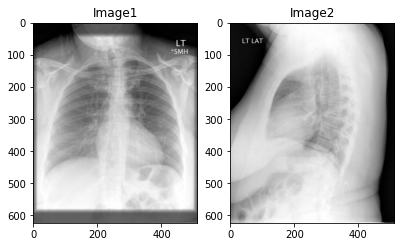

ACTUAL REPORT:  <sos> lungs are clear without focal consolidation effusion pneumothora .  normal heart size .  bony thora and soft tissues grossly unremarkable .  <eos>
GENERATED REPORT:  <sos> the mediastinal contours . no pleural effusion . degenerative changes . the right humerus .
BLEU SCORE IS:  0.5
time required for the evaluation is  4.28521203994751


In [ ]:
#checking on random test points
import random 
start=time.time()
#i=random.sample(range(test_dataset.shape[0]),1)[0]
i=98
img1=test_dataset.iloc[i]["Image-1"]
img2=test_dataset.iloc[i]["Image-2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("Image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("Image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
actual_ref = actual.split()
#actual_ref = [e for e in actual_ref if e not in ('SOS', 'EOS')]
result_ref = result.split()
#result_ref = [e for e in result_ref if e not in ('sos', 'eos')]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual_ref,result_ref,weights=(0.25,0.25,0.25,0.25)))

print("time required for the evaluation is ",end-start)

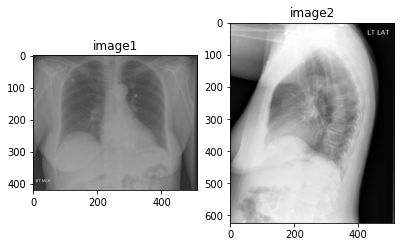

ACTUAL REPORT:  <sos> the cardiomediastinal silhouette normal size and contour .  no focal consolidation pneumothora large pleural effusion .  tspine osteophytes .  <eos>
GENERATED REPORT:  <sos> the mediastinal contours . no pleural effusion . no displaced rib .
BLEU SCORE IS:  0.5987028555414977
time required for the evaluation is  5.247561693191528


In [ ]:
#checking on random test points
import random 
start=time.time()
#i=random.sample(range(test_dataset.shape[0]),1)[0]
i = 73
img1=test_dataset.iloc[i]["Image-1"]
img2=test_dataset.iloc[i]["Image-2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
actual_ref = actual.split()
gen_ref  = result.split()
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual_ref,gen_ref,weights=(0.20,0.20,0.20,0.20,0.20)))

print("time required for the evaluation is ",end-start)

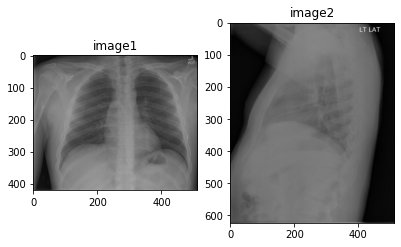

ACTUAL REPORT:  <sos> the heart normal size .  the mediastinum unremarkable .  there no pleural effusion pneumothora focal airspace disease .  there stable mild deformity the lower thoracic vertebral body .  <eos>
GENERATED REPORT:  <sos> the mediastinum . no pleural spaces .
BLEU SCORE IS:  0.5946035575013605
time required for the evaluation is  5.303972482681274


In [ ]:
#checking on random cv points
import random 
start=time.time()
i=random.sample(range(cv_dataset.shape[0]),1)[0]
img1=cv_dataset.iloc[i]["Image-1"]
img2=cv_dataset.iloc[i]["Image-2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=cv_report[i]
actual_ref = actual.split()
result_ref = result.split()
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual_ref,result_ref))

print("time required for the evaluation is ",end-start)

**CHECKING ON FULL TEST DATA**

In [ ]:
index=range(0,test_dataset.shape[0])
res=[]
start=time.time()
for i in tqdm(index):
  img_1=test_dataset.iloc[i]["Image-1"]
  img_2=test_dataset.iloc[i]["Image-2"]
  result,score=beam_search(img_1,img_2,3) 
  actual=test_report[i]
  actual_ref = actual.split()
  result_ref = result.split()
  res.append(bleu.sentence_bleu(actual_ref,result_ref,weights=(0.25,0.25,0.25,0.25)))
end=time.time() 

print("time taken for evaluation is ",end-start)

100%|██████████| 399/399 [29:45<00:00,  4.48s/it]

time taken for evaluation is  1785.96129488945


In [ ]:
#checking the maximum bleu score
max(res)

0.668740304976422

In [ ]:
np.mean(res)

0.5415717362774637

In [ ]:
np.median(res)

0.5491004867761125

In [ ]:
#saving in a pickle file
from pickle import dump
dump(res,open('test_res_att_w.pkl','wb'))

In [ ]:
'''#saving in a pickle file
from pickle import dump
dump(res,open('test_res_att.pkl','wb'))

In [ ]:
'''#saving in a pickle file
from pickle import dump
dump(res,open('test_res_att_50.pkl','wb'))

**PREDICTIONS ON CV DATA**

In [ ]:
index=range(0,cv_dataset.shape[0])
cv_res=[]
start=time.time()
for i in tqdm(index):
  img_1=cv_dataset.iloc[i]["Image-1"]
  img_2=cv_dataset.iloc[i]["Image-2"]
  result,score=beam_search(img_1,img_2,3) 
  actual=cv_report[i]
  actual_ref = actual.split()
  result_ref = result.split()
  cv_res.append(bleu.sentence_bleu(actual_ref,result_ref,weights=(0.25,0.25,0.25,0.25)))
end=time.time() 
print("time taken for evaluation is ",end-start)

100%|██████████| 550/550 [40:22<00:00,  4.40s/it]

time taken for evaluation is  2422.476996421814


In [ ]:
max(cv_res)

0.668740304976422

In [ ]:
min(cv_res)

0.33649324423301513

In [ ]:
np.mean(cv_res)

0.5444291127338224

In [ ]:
np.median(cv_res)

0.5557209059832308

In [ ]:
from pickle import dump
dump(cv_res,open('cv_res_att_w.pkl','wb'))

In [ ]:
'''from pickle import dump
dump(cv_res,open('cv_res_att.pkl','wb'))

In [ ]:
'''from pickle import dump
dump(cv_res,open('cv_res_att_50.pkl','wb'))

**PREDICTING ON TRAIN DATA**

In [ ]:
index=range(0,train_dataset.shape[0])
tr_res=[]
start=time.time()
for i in tqdm(index):
  img_1=train_dataset.iloc[i]["Image-1"]
  img_2=train_dataset.iloc[i]["Image-2"]
  result,score=beam_search(img_1,img_2,3) 
  actual=train_report[i]
  actual_ref = actual.split()
  result_ref = result.split()
  tr_res.append(bleu.sentence_bleu(actual_ref,result_ref,weights=(0.25,0.25,0.25,0.25)))
end=time.time() 
print("time taken for evaluation is ",end-start)

100%|██████████| 2758/2758 [3:23:21<00:00,  4.42s/it]

time taken for evaluation is  12201.18549156189


In [ ]:
max(tr_res)

0.668740304976422

In [ ]:
min(tr_res)

0.34449697505113935

In [ ]:
np.mean(tr_res)

0.5444135839012572

In [ ]:
np.median(tr_res)

0.5491004867761125

In [ ]:
from pickle import dump
dump(tr_res,open('tr_res_att_50_w.pkl','wb'))

In [ ]:
'''from pickle import dump
dump(tr_res,open('tr_res_att_50.pkl','wb'))

In [ ]:
'''from pickle import dump
dump(tr_res,open('tr_res_att.pkl','wb'))

**PLOTTING ON THE BLEU SCORES OF TRAIN,TEST AND CV DATA**

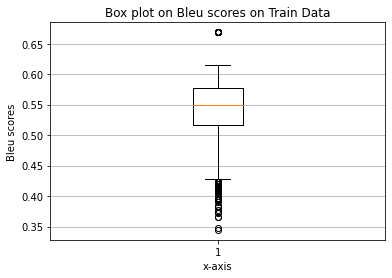

In [ ]:
#box plot on train predictions
fig, ax = plt.subplots()

data = tr_res
# build a box plot
ax.boxplot(data)


# title and axis labels
ax.set_title('Box plot on Bleu scores on Train Data')
ax.set_xlabel('x-axis')
ax.set_ylabel('Bleu scores')
ax.yaxis.grid(True)

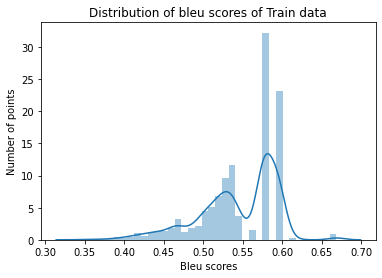

In [ ]:
#dist plot on train data predictions
pd.set_option('display.max_colwidth', -1)
sns.distplot(tr_res)


plt.xlabel('Bleu scores')
plt.ylabel('Number of points')
plt.title('Distribution of bleu scores of Train data')
plt.plot()
plt.savefig('bleu_train_gram.png', dpi=600)

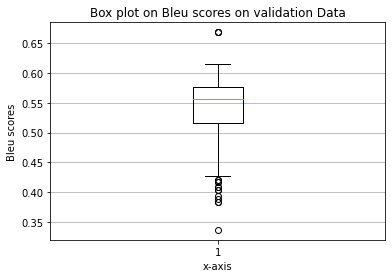

In [ ]:
#box plot on validation predictions
fig, ax = plt.subplots()

data = cv_res
# build a box plot
ax.boxplot(data)


# title and axis labels
ax.set_title('Box plot on Bleu scores on validation Data')
ax.set_xlabel('x-axis')
ax.set_ylabel('Bleu scores')
ax.yaxis.grid(True)

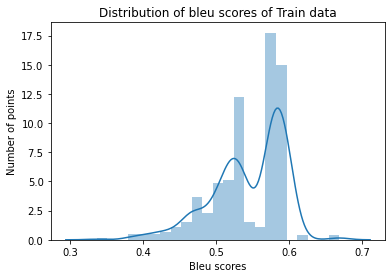

In [ ]:
#dist plot on cv predictions
pd.set_option('display.max_colwidth', -1)
sns.distplot(cv_res)


plt.xlabel('Bleu scores')
plt.ylabel('Number of points')
plt.title('Distribution of bleu scores of Train data')
plt.plot()
plt.savefig('bleu_validation_gram.png', dpi=600)

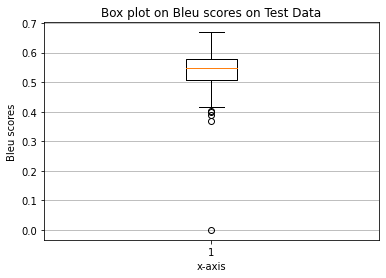

In [ ]:
#box plot on test data
fig, ax = plt.subplots()

data = res
# build a box plot
ax.boxplot(data)


# title and axis labels
ax.set_title('Box plot on Bleu scores on Test Data')
ax.set_xlabel('x-axis')
ax.set_ylabel('Bleu scores')
ax.yaxis.grid(True)

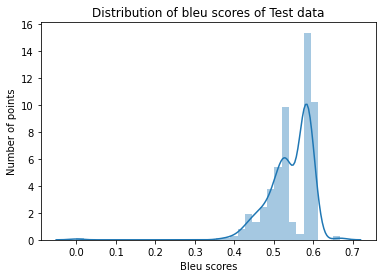

In [ ]:
#dist plot on test predictions
pd.set_option('display.max_colwidth', -1)
sns.distplot(res)


plt.xlabel('Bleu scores')
plt.ylabel('Number of points')
plt.title('Distribution of bleu scores of Test data')
plt.plot()
plt.savefig('bleu_test_gram.png', dpi=600)

**FINAL CONCLUSIONS**

In this model we got better results compared to first model as we used attention mechanism and beam search for predictions.
We can see that median blue score is greater than 0.54 on train,test and validation data.And we got a maximum score of greater than 0.65 on train,test and validation data

**Analysing Train Results**

In [24]:
#loading train results pickle file
import pickle
with open('tr_res_att_50_w.pkl', 'rb') as fp:
  tr_results = pickle.load(fp)

In [25]:
len(tr_results)

2758

In [26]:
min(tr_results),max(tr_results)

(0.34449697505113935, 0.668740304976422)

In [27]:
for i in range(1,100,10):
  print('{0} %  bleu score is '.format(i),(np.percentile(tr_results,i)))

1 %  bleu score is  0.40546144983876986
11 %  bleu score is  0.4728708045015879
21 %  bleu score is  0.5081327481546147
31 %  bleu score is  0.5266403878479265
41 %  bleu score is  0.537284965911771
51 %  bleu score is  0.5623413251903491
61 %  bleu score is  0.5773502691896257
71 %  bleu score is  0.5773502691896257
81 %  bleu score is  0.5946035575013605
91 %  bleu score is  0.5946035575013605


In [28]:
#checking for how many points the bleu scores is below 0.5
wor = 0
better = 0
wor_id = []
#avg_id = []
for i in tr_results:
  if i<0.50:
    wor+=1
    id = tr_results.index(i)
    wor_id.append(id)
  else:
    better+=1
print(wor,better)

415 2343


In [29]:
train_dataset['Bleu_scores'] = tr_results

In [30]:
train_dataset.head()

,Person_id,Image-1,Image-2,Findings,Bleu_scores
0,x ray data/CXR1_1_IM-0001_0,x ray data/CXR1_1_IM-0001-3001.png,x ray data/CXR1_1_IM-0001-4001.png,the cardiac silhouette and mediastinum size ar...,0.447214
1,x ray data/CXR10_IM-0002_0,x ray data/CXR10_IM-0002-1001.png,x ray data/CXR10_IM-0002-2001.png,the cardiomediastinal silhouette within normal...,0.451801
2,x ray data/CXR100_IM-0002_0,x ray data/CXR100_IM-0002-1001.png,x ray data/CXR100_IM-0002-2001.png,both lungs are clear and epanded . heart and ...,0.402767
3,x ray data/CXR1000_IM-0003_0,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-2001.png,there increased opacity within the right upper...,0.537285
4,x ray data/CXR1000_IM-0003_1,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-3001.png,there increased opacity within the right upper...,0.537285


In [31]:
#dividing the dataset based on bleu scores
wor_df = train_dataset.loc[train_dataset['Bleu_scores'] < 0.50]
print(wor_df.shape)

(415, 5)


In [53]:
best_df = train_dataset.loc[train_dataset['Bleu_scores'] >= 0.50]
print(best_df.shape)

(2343, 5)


In [54]:
wor_df.head()

,Person_id,Image-1,Image-2,Findings,Bleu_scores
0,x ray data/CXR1_1_IM-0001_0,x ray data/CXR1_1_IM-0001-3001.png,x ray data/CXR1_1_IM-0001-4001.png,the cardiac silhouette and mediastinum size ar...,0.447214
1,x ray data/CXR10_IM-0002_0,x ray data/CXR10_IM-0002-1001.png,x ray data/CXR10_IM-0002-2001.png,the cardiomediastinal silhouette within normal...,0.451801
2,x ray data/CXR100_IM-0002_0,x ray data/CXR100_IM-0002-1001.png,x ray data/CXR100_IM-0002-2001.png,both lungs are clear and epanded . heart and ...,0.402767
14,x ray data/CXR1008_IM-0009_0,x ray data/CXR1008_IM-0009-2001.png,x ray data/CXR1008_IM-0009-4004.png,heart size and mediastinal contours are normal...,0.420448
17,x ray data/CXR1010_IM-0012_0,x ray data/CXR1010_IM-0012-1001.png,x ray data/CXR1010_IM-0012-2001.png,cardiac and mediastinal contours are within no...,0.467138


In [55]:
#checking the length of report
leng=[]
for rep in wor_df["Findings"]:
  leng.append(len(rep.split()))
for i in range(0,100,10):
  print('{0} % reports length is '.format(i),np.percentile(leng,i))

0 % reports length is  11.0
10 % reports length is  18.0
20 % reports length is  21.0
30 % reports length is  25.0
40 % reports length is  28.0
50 % reports length is  30.0
60 % reports length is  33.0
70 % reports length is  37.0
80 % reports length is  41.0
90 % reports length is  49.0


In [56]:
for i in range(90,100,1):
  print('{0} % reports length is '.format(i),np.percentile(leng,i))

90 % reports length is  49.0
91 % reports length is  50.0
92 % reports length is  51.0
93 % reports length is  52.02000000000004
94 % reports length is  53.15999999999997
95 % reports length is  55.0
96 % reports length is  59.44
97 % reports length is  63.15999999999997
98 % reports length is  74.43999999999994
99 % reports length is  82.0


In [57]:

min(leng)

11

In [58]:
#findng length of reports in dataframe with bleu >0.5
leng=[]
for rep in best_df["Findings"]:
  leng.append(len(rep.split()))
for i in range(0,100,10):
  print('{0} % reports length is '.format(i),np.percentile(leng,i))

0 % reports length is  6.0
10 % reports length is  18.0
20 % reports length is  20.400000000000034
30 % reports length is  24.0
40 % reports length is  27.0
50 % reports length is  30.0
60 % reports length is  32.0
70 % reports length is  36.0
80 % reports length is  40.0
90 % reports length is  49.0


In [59]:
for i in range(90,100,1):
  print('{0} % reports length is '.format(i),np.percentile(leng,i))

90 % reports length is  49.0
91 % reports length is  50.0
92 % reports length is  51.0
93 % reports length is  52.0
94 % reports length is  54.0
95 % reports length is  56.0
96 % reports length is  57.0
97 % reports length is  60.0
98 % reports length is  65.0
99 % reports length is  72.0


In [60]:
min(leng)

6

Here we can see that the length of reports are same almost at all levels

In [61]:
#checking images 
wor_img_1 = wor_df['Image-1'].unique()
wor_img_2 = wor_df['Image-2'].unique()


In [62]:
len(wor_img_1),len(wor_img_2)

(408, 407)

In [63]:
#finding common images
img_1s = set (wor_img_1)
img_2s = set (wor_img_2)

print(len(img_1s & img_2s))

57


In [64]:
bes_img_1 = best_df['Image-1'].unique()
bes_img_2 = best_df['Image-2'].unique()

In [65]:
len(bes_img_1),len(bes_img_2)

(2244, 2249)

In [66]:
img_1s = set (bes_img_1)
img_2s = set (bes_img_2)

print(len(img_1s & img_2s))

328


Here we can see that there are about 57 points out of 400 points which has common images that means these points have only a single image and the same image is used as second image where as in well performed one there will 2 different images which could have impacted the result.

In [67]:
#getting words from reports in wor_df
words = []
for rep in wor_df['Findings']:
  x = rep.split()
  for i in x:
    words.append(i)

In [68]:
#getting words from reports in best_df
words_best = []
for rep in best_df['Findings']:
  x = rep.split()
  for i in x:
    words_best.append(i)

In [69]:
len(words),len(words_best)

(13655, 73803)

In [70]:
#converting both words list to sets to find unique words
word_set = set (words)
words_best_s = set (words_best)

In [71]:
len(word_set),len(words_best_s)

(729, 1354)

In [72]:
#checking how many common words are present in the words from wor_df and embedding file
t_ws = set (t_w)#from the embedding file
x_s  = set (word_set)
com = (x_s & t_ws)
print('{0} % of train words present in embedding file'.format(len(com)/len(t_ws)*100))

51.12201963534362 % of train words present in embedding file


In [73]:
#checking how many common words are present in the words from best_df and embedding file
t_ws = set (t_w)
x_s  = set (words_best)
com = (x_s & t_ws)
print('{0} % of train words present in embedding file'.format(len(com)/len(t_ws)*100))

94.95091164095372 % of train words present in embedding file


Here we can see that the only 51% of words which are present in findings of not well performed Dataframe are present in Embedding file

Where as About 96% of words present in findings of well performed dataframe are present in Embedding file.This could have impacted the outcome.

